# Predictive Analytics

### Predicting future bikesharing demand

Accurately predicting future demand is an important step towards providing a high service level (e.g. by deploying additional bikes or by re-positioning vehicles etc.)

Future demand is a key factor that will steer operational decision making of a shared rental network. As a data scientist it is your responsibility to facilitate this type of decision support. For the purpose of this assignment we will be interested in forecasting total system-level demand in the next hour. To do so, develop a prediction model that predicts bike rental demand as a function of suitable features available in or derived from the datasets (incl. the weather data). <br>
– Feature Engineering: Develop a rich set of features that you expect to be correlated with your target. In this process you can draw on your domain knowledge and/or conduct additional research around the topic of demand prediction in vehicle rental networks. Justify your selection of features. <br>
– Model Building: Select three regression algorithms that are suitable for the prediction task at hand. Explain and justify why you selected the three algorithms and describe their respective advantages and drawbacks. <br>
– Model Evaluation: How well do the models perform? Evaluate and benchmark your models’ performance using suitable evaluation metrics. Which model would you select for deployment? <br>
– Outlook: How could the selected model be improved further? Explain some of the improvement levers that you might focus on in a follow-up project. <br>

## Feature Engineering

Develop a rich set of features that you expect to be correlated with your target. In this process you can draw on your domain knowledge and/or conduct additional research around the topic of demand prediction in vehicle rental networks. Justify your selection of features.

In [119]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from datetime import date, time, datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV

In [120]:
#Import Dataset 
file_path = "./data/"

raw_data = pd.read_csv(f"{file_path}chicago_2017_prepared.csv")
raw_data.head()

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,start_hour,start_day,start_month,start_weekday,max_temp,min_temp,precip,start_lat,start_long,end_lat,end_long
0,2017-01-01 00:00:36,2017-01-01 00:06:32,414,191,Canal St & Taylor St,Canal St & Monroe St (*),2511,Customer,0,1,1,6,-0.6,-0.6,0.0,41.870257,-87.639474,41.880884,-87.639525
1,2017-01-01 00:02:54,2017-01-01 00:08:21,28,20,Larrabee St & Menomonee St,Sheffield Ave & Kingsbury St,3660,Subscriber,0,1,1,6,-0.6,-0.6,0.0,41.914680,-87.643320,41.910522,-87.653106
2,2017-01-01 00:06:06,2017-01-01 00:18:31,620,333,Orleans St & Chestnut St (NEXT Apts),Ashland Ave & Blackhawk St,4992,Subscriber,0,1,1,6,-0.6,-0.6,0.0,41.898203,-87.637536,41.907066,-87.667252
3,2017-01-01 00:07:28,2017-01-01 00:12:51,287,68,Franklin St & Monroe St,Clinton St & Tilden St,5637,Subscriber,0,1,1,6,-0.6,-0.6,0.0,41.880317,-87.635185,41.875885,-87.640795
4,2017-01-01 00:07:57,2017-01-01 00:20:53,300,118,Broadway & Barry Ave,Sedgwick St & North Ave,2209,Subscriber,0,1,1,6,-0.6,-0.6,0.0,41.937725,-87.644095,41.911386,-87.638677


Our task is to predict the trip demand in the next hour in the network. To do so, we decided to fit the data into a format where one data sample (one row) contains measurements on the following features:

month
day
hour
weekday
maximum temperature
precipitation

The target would then be the number of trips within that hour.

In [121]:
raw_data = raw_data[["start_month", "start_day", "start_hour", "start_weekday", "bike_id", "max_temp", "min_temp", "precip"]]
raw_data.rename(columns={"start_month": "month", "start_day": "day", "start_hour": "hour", "start_weekday": "weekday"}, inplace=True)
trip_number = raw_data.groupby(["month", "day", "hour"])['bike_id'].count()

raw_data['temp'] = raw_data['min_temp'] + ((raw_data['max_temp'] - raw_data['min_temp']) /2)
raw_data.drop(['max_temp', 'min_temp'], axis=1, inplace=True)

raw_data.drop('bike_id', axis=1, inplace=True)
raw_data.drop_duplicates(inplace=True)
raw_data['trips'] = trip_number.values
raw_data = raw_data.reset_index(drop=True)

raw_data

,month,day,hour,weekday,precip,temp,trips
0,1,1,0,6,0.0,-0.6,46
1,1,1,1,6,0.0,-2.2,46
2,1,1,2,6,0.0,-2.8,36
3,1,1,3,6,0.0,-3.3,18
4,1,1,4,6,0.0,-3.3,6
...,...,...,...,...,...,...,...
8738,12,31,19,6,0.0,-11.1,20
8739,12,31,20,6,0.0,-10.6,20
8740,12,31,21,6,0.0,-10.6,13
8741,12,31,22,6,0.0,-11.7,9


As we can see, we only have trip data for 8743 hours of the year. A year has 365 * 24 = 8760 hours. So there were 17 hours in the year were we are missing trip data, most likely because there simply were no trips during these hours. We will look look at these missing hours after creating a new data frame implementing all hours and merging both dataframes

In [122]:
hourly_2017 = (datetime(year=2017, month=1, day=1, hour=0)) + pd.to_timedelta(np.arange(365 * 24), 'H')

hourly_2017_df = pd.DataFrame(hourly_2017)
hourly_2017_df[0] = pd.to_datetime(hourly_2017_df[0])
hourly_2017_df["month"] = hourly_2017_df[0].apply(lambda date: date.month)
hourly_2017_df["day"] = hourly_2017_df[0].apply(lambda date: date.day)
hourly_2017_df["hour"] = hourly_2017_df[0].apply(lambda date: date.hour)
hourly_2017_df["weekday"] = hourly_2017_df[0].apply(lambda date: date.weekday())
hourly_2017_df = hourly_2017_df.drop(0, 1)

hourly_bikesharing_demand = pd.merge(hourly_2017_df, raw_data, on=['month', 'day', 'hour', 'hour' , 'weekday'], how='left')
hourly_bikesharing_demand[hourly_bikesharing_demand["trips"].isnull() == True]

,month,day,hour,weekday,precip,temp,trips
195,1,9,3,0,NaN,NaN,NaN
387,1,17,3,1,NaN,NaN,NaN
938,2,9,2,3,NaN,NaN,NaN
963,2,10,3,4,NaN,NaN,NaN
1562,3,7,2,1,NaN,NaN,NaN
1682,3,12,2,6,NaN,NaN,NaN
2114,3,30,2,3,NaN,NaN,NaN
8472,12,20,0,2,NaN,NaN,NaN
8473,12,20,1,2,NaN,NaN,NaN
8474,12,20,2,2,NaN,NaN,NaN


These 17 missing values will be filled with 0 since there were no trips and the missing weather data will be filled forward filled just like in the data preperation

In [123]:
hourly_bikesharing_demand['trips'] = hourly_bikesharing_demand['trips'].fillna(0)
hourly_bikesharing_demand = hourly_bikesharing_demand.fillna(method='ffill')
hourly_bikesharing_demand.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8760 entries, 0 to 8759
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   month    8760 non-null   int64  
 1   day      8760 non-null   int64  
 2   hour     8760 non-null   int64  
 3   weekday  8760 non-null   int64  
 4   precip   8760 non-null   float64
 5   temp     8760 non-null   float64
 6   trips    8760 non-null   float64
dtypes: float64(3), int64(4)
memory usage: 547.5 KB


Our precipitation as well as trip count are in float, while they should simply be an int (0 or 1). Weekday will be transformed to a weekend or not feature 

In [124]:
def weekend_(x):
    if x >= 5:
        return '1'
    else:
        return '0'

hourly_bikesharing_demand['weekend'] = hourly_bikesharing_demand['weekday'].apply(weekend_)

In [125]:
hourly_bikesharing_demand['precip'] = hourly_bikesharing_demand['precip'].apply(lambda precip: int(precip))
hourly_bikesharing_demand['trips'] = hourly_bikesharing_demand['trips'].apply(lambda count: int(count))
hourly_bikesharing_demand

,month,day,hour,weekday,precip,temp,trips,weekend
0,1,1,0,6,0,-0.6,46,1
1,1,1,1,6,0,-2.2,46,1
2,1,1,2,6,0,-2.8,36,1
3,1,1,3,6,0,-3.3,18,1
4,1,1,4,6,0,-3.3,6,1
...,...,...,...,...,...,...,...,...
8755,12,31,19,6,0,-11.1,20,1
8756,12,31,20,6,0,-10.6,20,1
8757,12,31,21,6,0,-10.6,13,1
8758,12,31,22,6,0,-11.7,9,1


In [126]:
hourly_bikesharing_demand.describe()

,month,day,hour,weekday,precip,temp,trips
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,6.526027,15.720548,11.500000,3.008219,0.087443,11.517888,437.095205
std,3.448048,8.796749,6.922582,2.003519,0.282499,10.915560,498.340244
min,1.000000,1.000000,0.000000,0.000000,0.000000,-19.400000,0.000000
25%,4.000000,8.000000,5.750000,1.000000,0.000000,3.300000,57.750000
50%,7.000000,16.000000,11.500000,3.000000,0.000000,11.700000,234.500000
75%,10.000000,23.000000,17.250000,5.000000,0.000000,20.600000,660.000000
max,12.000000,31.000000,23.000000,6.000000,1.000000,35.000000,2852.000000


## Model Building

Select three regression algorithms that are suitable for the prediction task at hand. Explain and justify why you selected the three algorithms and describe their respective advantages and drawbacks.

In [127]:
X_full = hourly_bikesharing_demand[['temp', 'weekend', 'month', 'hour']]
scaler = StandardScaler()
X = scaler.fit_transform(X_full)
#y_full = hourly_bikesharing_demand['trips'].values.reshape(-1, 1)
#y = scaler.fit_transform(y_full)
y = hourly_bikesharing_demand['trips']

X_train, X_temp, y_train, y_temp = train_test_split(X, y,
    test_size=0.5, shuffle = True, random_state = 8)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp,
    test_size=0.4, shuffle = True, random_state = 8) # 0,4 * 0,5 = 0,2

print('Size of training data set: ' + str(len(X_train)))
print('Size of validation data set: ' + str(len(X_validation)))
print('Size of test data set: ' + str(len(X_test)))

Size of training data set: 4380
Size of validation data set: 2628
Size of test data set: 1752


In [128]:
#include_bias = False erschafft keinen künstlichen Intercept, interaction_only = False nicht nur Features mit degree distinct input Features werden produziert
def get_poly_features(features, degree):
    poly_features = PolynomialFeatures(degree = degree, include_bias = False, interaction_only = False)
    return_features = poly_features.fit_transform(features)
    return return_features

def eval(val_target, val_pred):
    MAE = mean_absolute_error(val_target, val_pred)
    MSE = mean_squared_error(val_target, val_pred)
    R2 = r2_score(val_target, val_pred)

    print("MAE: " + str(MAE))
    print("MSE: " + str(MSE))
    print("R^2: " + str(R2))

In [129]:
def simple_poly_regression(X_t, y_t, d, X_val, y_val):
    poly_reg = LinearRegression()
    poly_reg.fit(get_poly_features(X_t, d), y_t)

    pred = poly_reg.predict(get_poly_features(X_val, d))
    eval(y_val, pred)

Tryout with degree 10

In [130]:
simple_poly_regression(X_train, y_train, 10, X_validation, y_validation)

MAE: 137.2609003660083
MSE: 42937.996236420535
R^2: 0.8234041894581152


In [131]:
def ridge_reg(X_t, y_t, regu_param, d, X_val, y_val):
    model_L2 = Ridge(alpha = regu_param, normalize = True, solver = 'lsqr')
    model_L2.fit(get_poly_features(X_t, d), y_t)

    pred = model_L2.predict(get_poly_features(X_val, d))
    eval(y_val, pred)

In [132]:
#should have the same results as linear regression, but there may be computational complications when running with 0, according to the sklearn documentation, as in this case
ridge_reg(X_train, y_train, 0, 10, X_validation, y_validation)

MAE: 172.06846795415416
MSE: 61491.61406483643
R^2: 0.7470966887342154


In [133]:
ridge_reg(X_train, y_train, 1, 10, X_validation, y_validation)

MAE: 235.08145490506035
MSE: 110562.59940902198
R^2: 0.5452770606539694


In [134]:

def lasso_reg(X_t, y_t, regu_param, d, X_val, y_val):
    model_L1 = Lasso(alpha = regu_param)
    model_L1.fit(get_poly_features(X_t, d), y_t)

    pred = model_L1.predict(get_poly_features(X_val, d))
    eval(y_val, pred)

In [135]:
lasso_reg(X_train, y_train, 1, 10, X_validation, y_validation)

MAE: 158.8801601880075
MSE: 57679.979129014086
R^2: 0.7627732181482816


In [136]:
#Try out of dummied features
norm = StandardScaler()
Copy = hourly_bikesharing_demand.copy()
##Copy['trips_norm'] = norm.fit_transform(Copy["trips"].values.reshape(-1, 1))
Copy['temp_norm'] = norm.fit_transform(Copy["temp"].values.reshape(-1, 1))

#Copy = pd.get_dummies(Copy, columns=['weekday'])

Copy = pd.get_dummies(Copy, columns=['month'])
#Copy['month_norm'] = norm.fit_transform(Copy["month"].values.reshape(-1, 1))

Copy = pd.get_dummies(Copy, columns=['hour'])

#Copy['hour_norm'] = norm.fit_transform(Copy["hour"].values.reshape(-1, 1))

In [137]:
X2 = Copy[['temp_norm', 'precip', 'weekend', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23']]
#y_full = Copy['trips'].values.reshape(-1, 1)
#y = scaler.fit_transform(y_full)
y2 = Copy['trips']

X_train2, X_temp2, y_train2, y_temp2 = train_test_split(X2, y2,
    test_size=0.5, shuffle = True, random_state = 8)
X_validation2, X_test2, y_validation2, y_test2 = train_test_split(X_temp2, y_temp2,
    test_size=0.4, shuffle = True, random_state = 8) # 0,4 * 0,5 = 0,2

print('Size of training data set: ' + str(len(X_train2)))
print('Size of validation data set: ' + str(len(X_validation2)))
print('Size of test data set: ' + str(len(X_test2)))

Size of training data set: 4380
Size of validation data set: 2628
Size of test data set: 1752


In [138]:
simple_poly_regression(X_train2, y_train2, 2, X_validation2, y_validation2)

MAE: 114.69845697179414
MSE: 32972.26307474278
R^2: 0.8643913541977182


In [139]:
ridge_reg(X_train2, y_train2, 0.05, 3, X_validation2, y_validation2)

MAE: 102.89544806932194
MSE: 33610.67438059117
R^2: 0.8617656899400142


In [140]:
lasso_reg(X_train2, y_train2, 0.05, 3, X_validation2, y_validation2)

MAE: 101.31906915428004
MSE: 29706.003591068933
R^2: 0.8778248581223901


In [141]:
def simple_poly_regression_noeval(X_t, y_t, d):
    poly_reg = LinearRegression()
    poly_reg.fit(get_poly_features(X_t, d), y_t)

    return poly_reg

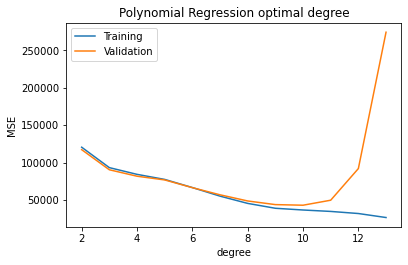

In [142]:
performance_train_set = list()
performance_valid_set = list()

min_degree = 2
max_degree = 13 # can take a long time for high numbers (5min for 18)

for d in range(min_degree, max_degree + 1):
    model = simple_poly_regression_noeval(X_train, y_train, d)
    
    y_model = model.predict(get_poly_features(X_train, d))
    performance_train_set.append(mean_squared_error(y_train, y_model))

    y_model = model.predict(get_poly_features(X_validation, d))
    performance_valid_set.append(mean_squared_error(y_validation, y_model))

rcParams['figure.figsize'] = 6, 3.75
plt.plot(np.linspace(min_degree, max_degree, max_degree + 1 - min_degree), performance_train_set)
plt.plot(np.linspace(min_degree, max_degree, max_degree + 1 - min_degree), performance_valid_set)

plt.title("Polynomial Regression optimal degree")
plt.legend(["Training", "Validation"])
plt.xlabel("degree")
plt.ylabel("MSE")
plt.show()

Text(0, 0.5, 'MSE')

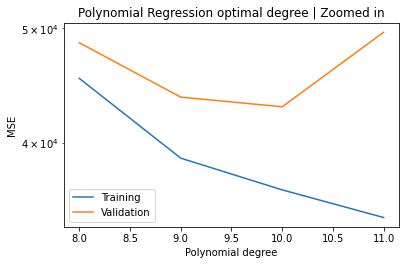

In [143]:
#Both list start with [0] = degree 2
plt.semilogy(range(8, 12), performance_train_set[6:10], range(8, 12), performance_valid_set[6:10])
plt.title("Polynomial Regression optimal degree | Zoomed in")
plt.legend(["Training", "Validation"])
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")

Best degree for polynomial regression 10
Before calculating optimal degree for Ridge & Lasso first regularization parameter

In [144]:
def ridge_reg_noeval(X_t, y_t, regu_param, d):
    model_L2 = Ridge(alpha = regu_param, normalize = True, solver = 'lsqr')
    model_L2.fit(get_poly_features(X_t, d), y_t)

    return model_L2

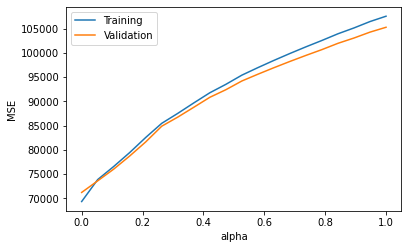

In [145]:
# ridge regression (L2) prediction

# tune hyperparameter a
performance_train_set = list()
performance_valid_set = list()

degree = 18 # increasing this will drastically increase runtime

min_alpha = 1e-6
max_alpha = 1
steps_alpha = 20 # increasing this will increase runtime

for a in np.linspace(min_alpha, max_alpha, steps_alpha):
    model = ridge_reg_noeval(X_train, y_train, a, degree)
    
    y_model = model.predict(get_poly_features(X_train, degree))
    performance_train_set.append(mean_squared_error(y_train, y_model))

    y_model = model.predict(get_poly_features(X_validation, degree))
    performance_valid_set.append(mean_squared_error(y_validation, y_model))

rcParams['figure.figsize'] = 6, 3.75
plt.plot(np.linspace(min_alpha, max_alpha, steps_alpha), performance_train_set)
plt.plot(np.linspace(min_alpha, max_alpha, steps_alpha), performance_valid_set)

plt.legend(["Training", "Validation"])
plt.xlabel("alpha")
plt.ylabel("MSE")
plt.show()

Next is Lasso regression. It uses a different regularization term compared to Ridge regression.

In [146]:
# lasso regression
def lasso_regression(X, y, d, alpha):
    model = Lasso(alpha=alpha)
    model.fit(poly_features(X, d), y)
    return model

# test lasso prediction with degree = 8
model = lasso_regression(X_train, y_train, 8, 10)

y_model = model.predict(poly_features(X_valid, 8))

evaluate(y_valid, y_model)

NameError: name 'poly_features' is not defined